## Making a custom dataset

https://youtu.be/Z_ikDlimN6A?si=v4XAXoJFhLF5GdRG&t=71647


In [2]:
## Imports and setting up domain-agnostic code

import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# get data
# will use a subset of the Food101 dataset
# pared to 3 classes and 10% of the images (~75 train / 25 test)

import requests
import zipfile
from pathlib import Path

# create data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# create if doesn't exist, download, prepare
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating path...")
  image_path.mkdir(parents=True, exist_ok=True)

# download custom data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi data")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating path...
Unzipping pizza_steak_sushi data


## Exploring the data

In [5]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path and returns its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [7]:
# set up training and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

steak
Random image path: data/pizza_steak_sushi/train/steak/3518960.jpg
Image class: steak
Image height: 512
Image width: 384


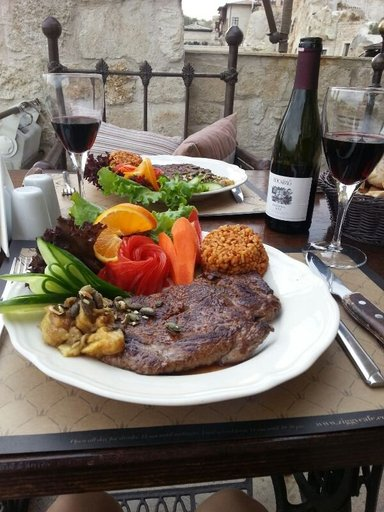

In [8]:
# visualize images
import random
from PIL import Image

# set seed for debugging
# random.seed(42)

# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# pick a random imagepath
random_image_path = random.choice(image_path_list)

# get image class name using `pathlib.Path.parent.stem`
image_class = random_image_path.parent.stem
print(image_class)

# display using Python's PIL
img = Image.open(random_image_path)

# print metadata

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

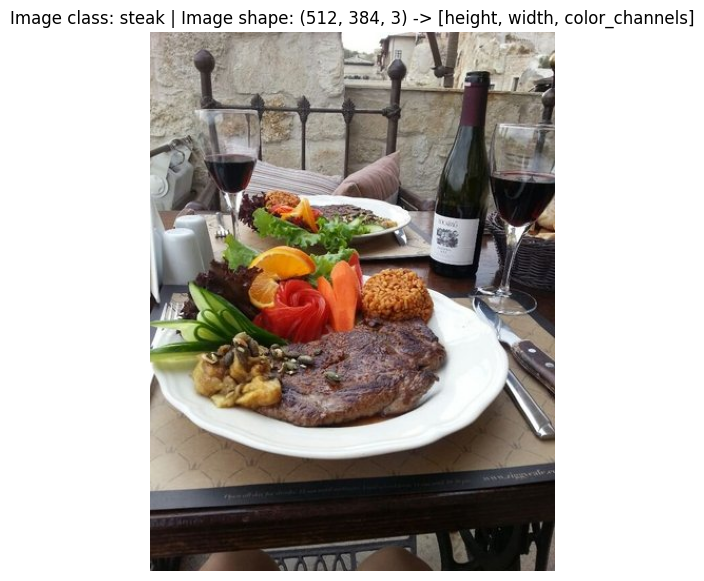

In [9]:
# can also visualize using Matplotlib

import numpy as np
import matplotlib.pyplot as plt

# turn image into array
img_as_array = np.asarray(img)

# plot using matplotlib.pyplot
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Transforming data

1. Before we can do PyTorch tasks, we need to turn our data into tensors

2. Next, aggregate dataset into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader` class

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
# create a (composite) transform

data_transform = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.ToTensor()
])

In [12]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Plots a series of random images from list of image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
      image_paths (list): List of target image paths.
      transform (PyTorch Transforms): Transforms to apply to images.
      n (int, optional): Number of images to plot. Defaults to 3.
      seed (int, optional): Random seed for the random generator. Defaults to 42.
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

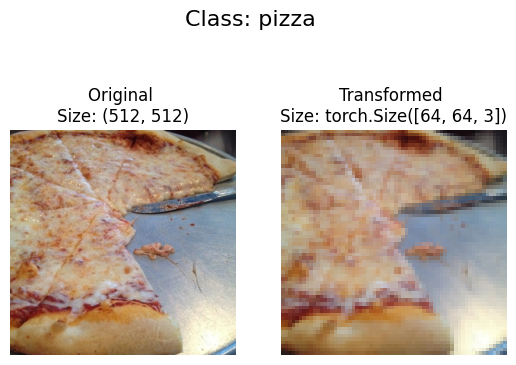

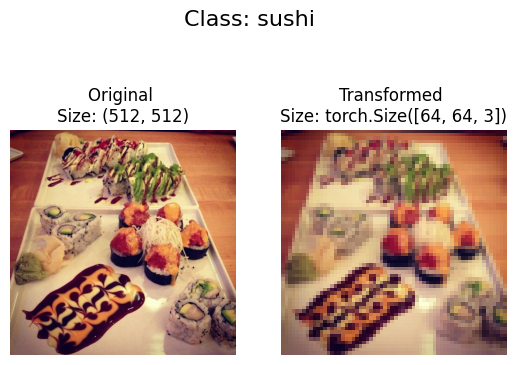

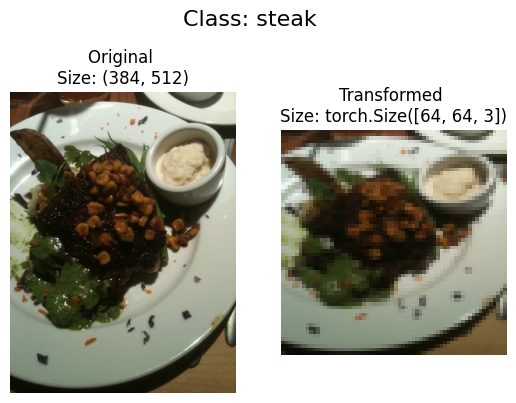

In [14]:
plot_transformed_images(image_path_list, transform=data_transform, n=3, seed=420)

## Loading images: Option 1 using `ImageFolder`
`torchvision.datasets.ImageFolder`

In [15]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the label/target


In [16]:
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# get classnames as a list
class_names = train_data.classes
print(class_names)

# get classnames as a dict
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [18]:
len(train_data), len(test_data)

(225, 75)

In [19]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [20]:
# index on the train_data dataset

train_data[0] # (tensor, integer label)

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


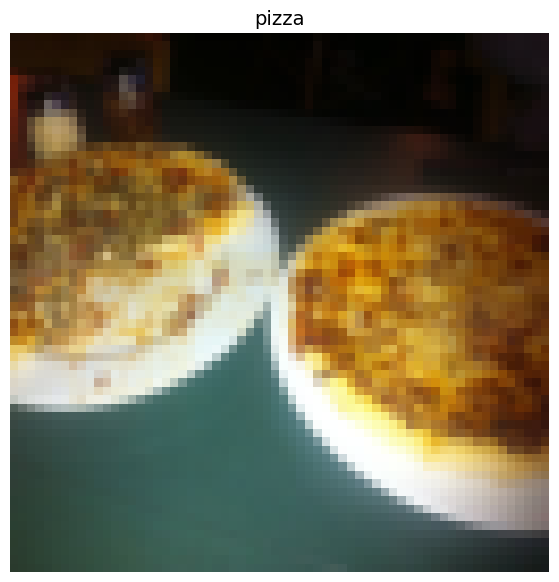

In [22]:
# plot in matplotlib
# first need to permute to put color channels last (PyTorch tensor has them first)

img_permute = img.permute(1,2,0)


# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

## Option 2: turn loaded images into `Dataloader` iterable w/ batching

In [23]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
NUM_CPUS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_CPUS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_CPUS,
                              shuffle=False)

In [24]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a4b5df90dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4b5dfb3160>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


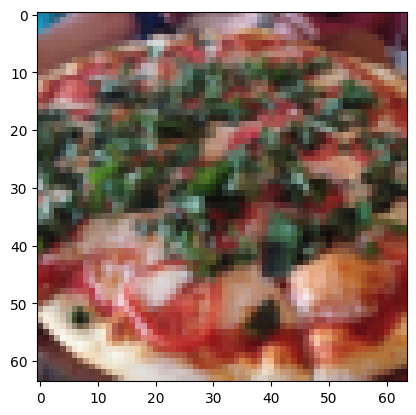

In [27]:
plt.imshow(img[0].permute(1, 2, 0)) # note that this is a batch of size BATCH_SIZE now

## Create a custom `Dataset` to replicate `ImageFolder`

just for some practice or if you're doing a generic deep learning task not in vision, recommender, audio, etc. with dataset support.

Building on top of: `torch.utils.data.Dataset`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

Pros:
can build out of almost anything
not limited to pre-built dataset functions

Cons:
custom code more brittle
can make an iterable, but that doesn't mean it will work with training

In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [29]:
# creating helper functions to get classnames in list and dict format

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds class folder names for file path in standard image format"""
  classes = sorted([entry.name for entry in list(os.scandir(directory))])

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [30]:
find_classes('data/pizza_steak_sushi')

(['test', 'train'], {'test': 0, 'train': 1})

In [31]:
from torch.utils.data import Dataset #ABC

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index:int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int):
    """returns one sample in form of tuple (image tensor, label integer)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
        return self.transform(img), class_idx # return data, label (X, y)
    else:
        return img, class_idx # return data, label (X, y)

In [32]:
# create a transform to test our class

train_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.ToTensor()
                                       ])

test_transforms = transforms.Compose([
                                        transforms.Resize(size=(64, 64)),
                                        transforms.ToTensor()
                                      ])

In [33]:
# test this puppy out!
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [34]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a4b5db3b550>,
 <__main__.ImageFolderCustom at 0x7a4b5db1b9d0>)

In [35]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
test_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [39]:
# display some random images from these custom data classes

# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

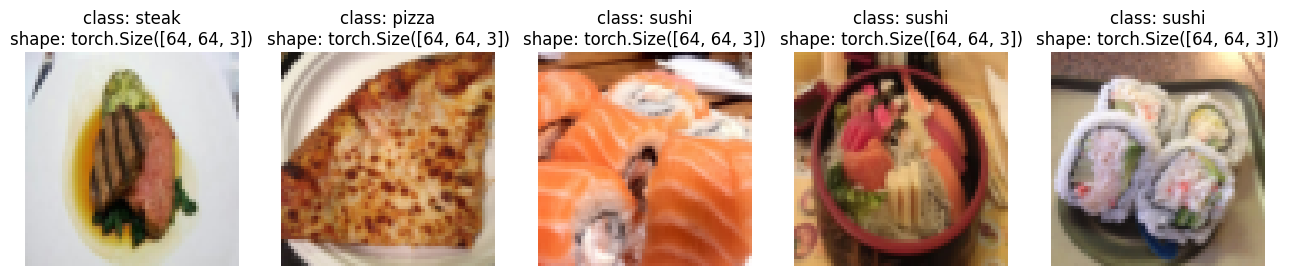

In [40]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

In [41]:
print(display_random_images)

<function display_random_images at 0x7a4b5df85d80>


## Turn custom data class we just wrote into Dataloader

In [42]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a4b5d2f3c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4b5d2f3250>)

In [43]:
# get a single sample and make sure it looks good

img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape # <- should be batch size

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## A glimpse at PyTorch data augmentation:
artificially adding diversity to training data
augmentation also helps keep model from learning contextual features instead of corrent semantics of the label (e.g. horses are almost always outside, kittens not)

Augmentation available and documented in transforms.
https://pytorch.org/vision/stable/transforms.html

In [44]:
from torchvision import transforms

train_transform = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                        transforms.ToTensor()
])

test_transform = transforms.Compose([
                                        transforms.Resize(size=(224, 224)),
                                        transforms.ToTensor()
])

In [45]:
image_path

PosixPath('data/pizza_steak_sushi')

In [46]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/pizza/1633289.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/3196721.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2760984.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/393658.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/220190.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2285942.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2885050.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1044789.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/2493954.jpg')]

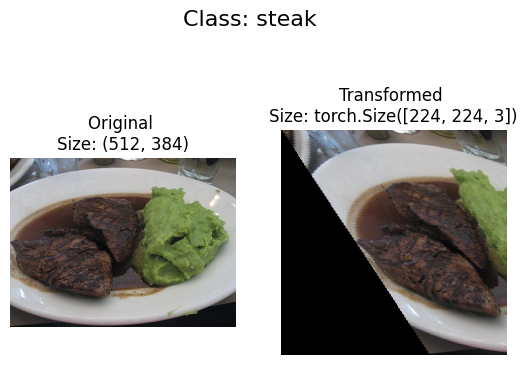

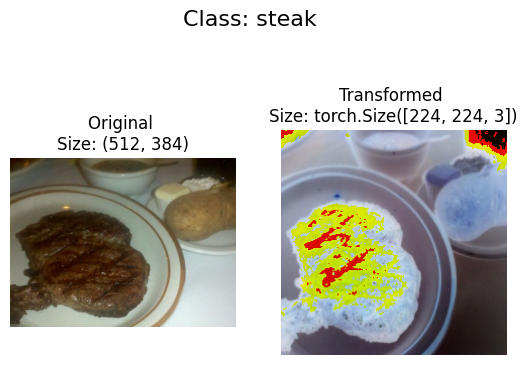

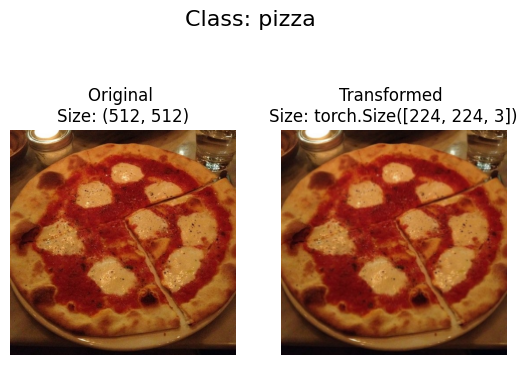

In [47]:
# plot some random transformed images

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## Try this out as the training dataset for a TinyVGG model
* first without augmentation transforms
* next with augmentation transforms

In [48]:
simple_transform = transforms.Compose([
                                          transforms.Resize(size=(64,64)),
                                          transforms.ToTensor()
])

In [49]:
# 1. load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)


# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple


Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7a4b5d016ce0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4b5d016a40>)

# Create TinyVGG model

In [50]:
class TinyVGG(nn.Module):
  """
  Model architecture
  """

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3, # how big is the square that's going over the image?
                  stride=1, # default
                  padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                      stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        # Where did this in_features shape come from?
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
      x = self.conv_block_1(x)
      # print(x.shape)
      x = self.conv_block_2(x)
      # print(x.shape)
      x = self.classifier(x)
      # print(x.shape)
      return x
      # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion
      # see https://horace.io/brrr_intro.html

In [51]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [52]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1).item()}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
1

Actual label:
2


In [53]:
# using torchinfo to get well-formatted summary info for model
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the model using the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the test dataloader data

In [54]:
# create train_step()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # loop through the dataloader data batches
  for batch, (X, y) in enumerate(dataloader):
    # send data to target device
    X, y = X.to(device), y.to(device)

    # 1. forward pass
    y_pred = model(X)

    # 2. calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # adjust metrics to get average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [55]:
# create a test step function
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device):

  # put model in eval mode
  model.eval()

  # initialize test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():
    # loop through batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # 1. forward pass
      test_pred_logits = model(X)

      # 2. calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## create a `train()` function to combine `train_step()` and `test_step()`

In [56]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(), # default for multi-class classifier
          epochs: int = 5,
          device = device):
  # create an empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## Train the model!

In [57]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0005)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1048 | train_acc: 0.2930 | test_loss: 1.1212 | test_acc: 0.2083
Epoch: 2 | train_loss: 1.1055 | train_acc: 0.2969 | test_loss: 1.1114 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.1048 | train_acc: 0.3047 | test_loss: 1.1145 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.0892 | train_acc: 0.4336 | test_loss: 1.1016 | test_acc: 0.2812
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.3438 | test_loss: 1.0974 | test_acc: 0.3021
Epoch: 6 | train_loss: 1.0778 | train_acc: 0.4648 | test_loss: 1.1003 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.0314 | train_acc: 0.5820 | test_loss: 1.0960 | test_acc: 0.3125
Epoch: 8 | train_loss: 1.0295 | train_acc: 0.4023 | test_loss: 1.1075 | test_acc: 0.3125
Epoch: 9 | train_loss: 0.9681 | train_acc: 0.5625 | test_loss: 0.9802 | test_acc: 0.4830
Epoch: 10 | train_loss: 0.9909 | train_acc: 0.4570 | test_loss: 0.9365 | test_acc: 0.5653
Epoch: 11 | train_loss: 0.8626 | train_acc: 0.6289 | test_loss: 1.0868 | test_acc: 0.4242
Epoch: 12 | train_l

## Plot model results using loss curves

In [58]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [59]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

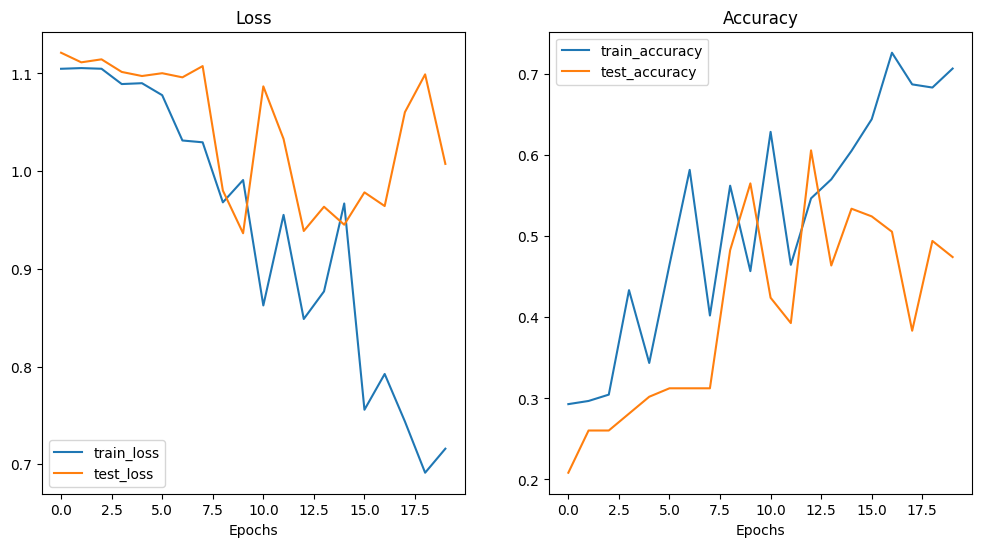

In [60]:
plot_loss_curves(model_0_results)

## Model 1 using data augmentation transforms

In [61]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [64]:
# turn image folders into new Datasets with new transforms
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial_augment)
test_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=test_transform)

In [65]:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)


In [68]:
# Construct the model and send to the device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_timer = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()
print(f"Total training time for model_1: {end_time - start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1045 | train_acc: 0.2500 | test_loss: 1.0989 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0965 | train_acc: 0.3906 | test_loss: 1.1007 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0826 | train_acc: 0.4258 | test_loss: 1.1269 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1086 | train_acc: 0.3047 | test_loss: 1.1309 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0708 | train_acc: 0.4609 | test_loss: 1.1231 | test_acc: 0.3021
Epoch: 6 | train_loss: 1.0762 | train_acc: 0.3750 | test_loss: 1.1367 | test_acc: 0.2917
Epoch: 7 | train_loss: 1.0052 | train_acc: 0.5508 | test_loss: 1.0651 | test_acc: 0.3220
Epoch: 8 | train_loss: 0.9893 | train_acc: 0.5547 | test_loss: 1.2443 | test_acc: 0.3021
Epoch: 9 | train_loss: 1.0904 | train_acc: 0.4219 | test_loss: 1.0137 | test_acc: 0.4223
Epoch: 10 | train_loss: 1.0175 | train_acc: 0.4102 | test_loss: 0.9757 | test_acc: 0.5331
Epoch: 11 | train_loss: 0.9941 | train_acc: 0.5234 | test_loss: 1.0281 | test_acc: 0.3617
Epoch: 12 | train_l

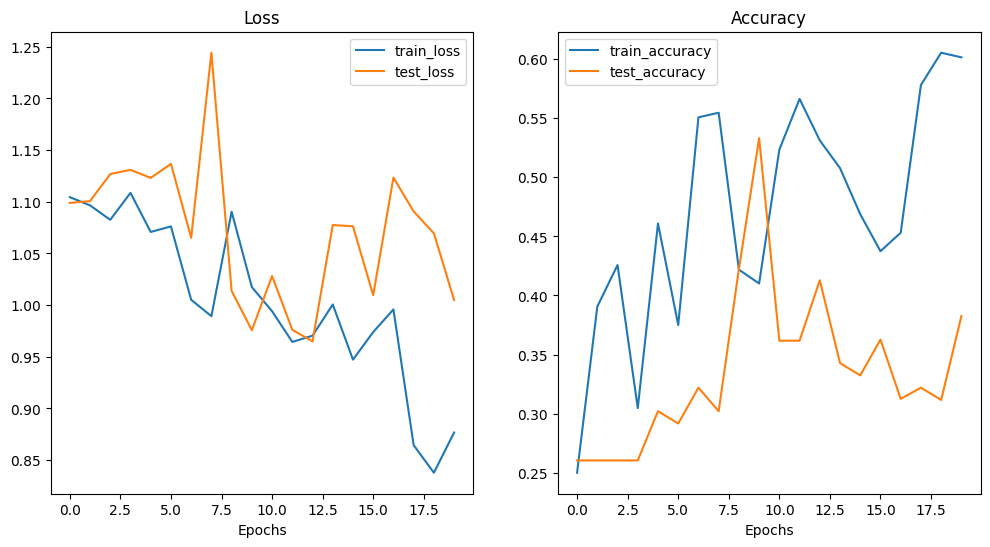

In [70]:
plot_loss_curves(model_1_results)

## Compare models

note that as well as manual comparison (as done here) there are many tools which help compare deep learning models
1. PyTorch tensorboard
2. Weighs & Biases
3. MLFlow

In [71]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.104784,0.292969,1.121217,0.208333
1,1.105489,0.296875,1.111384,0.260417
2,1.104818,0.304688,1.114451,0.260417
3,1.089153,0.433594,1.101554,0.281250
4,1.090033,0.343750,1.097379,0.302083
5,1.077764,0.464844,1.100251,0.312500
6,1.031407,0.582031,1.096025,0.312500
7,1.029546,0.402344,1.107526,0.312500
8,0.968095,0.562500,0.980180,0.482955
9,0.990945,0.457031,0.936472,0.565341


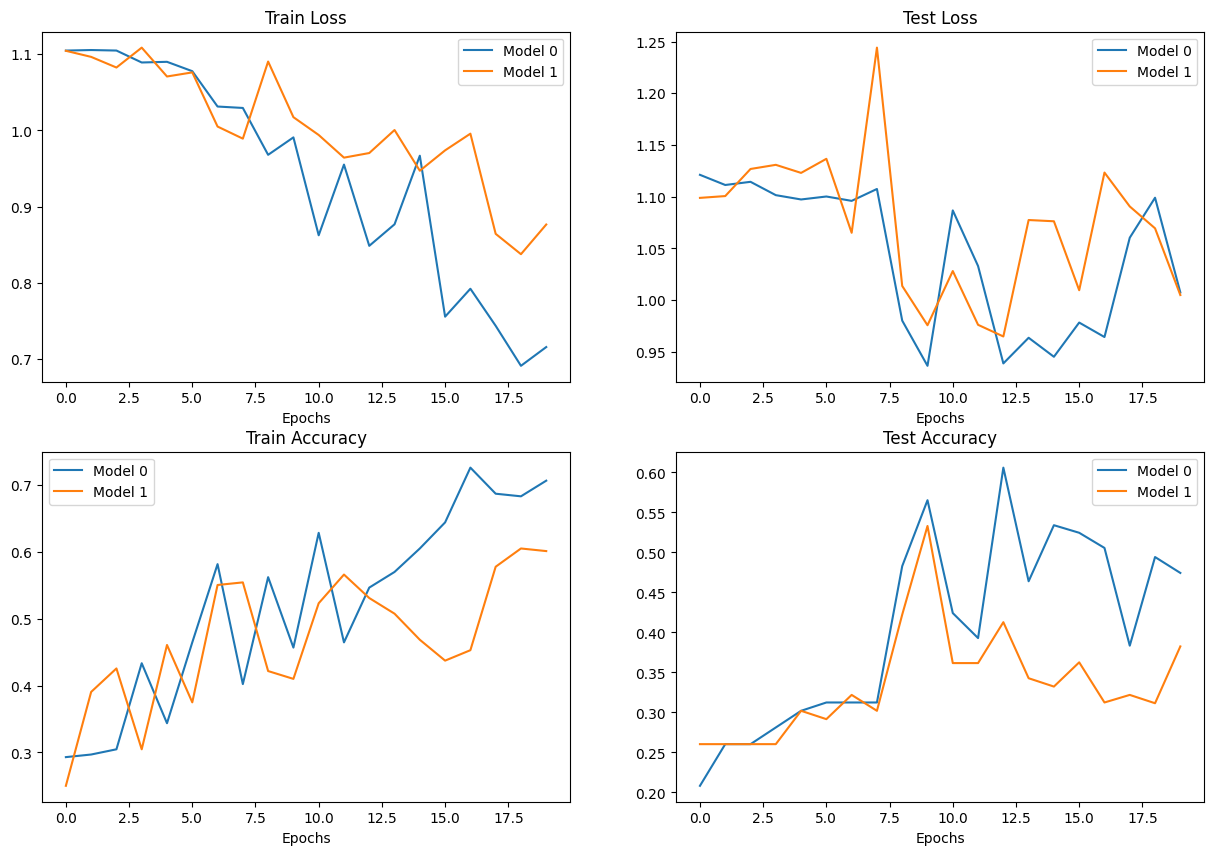

In [74]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## Inference on new data (make a prediction on new data)

In [79]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

In [80]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

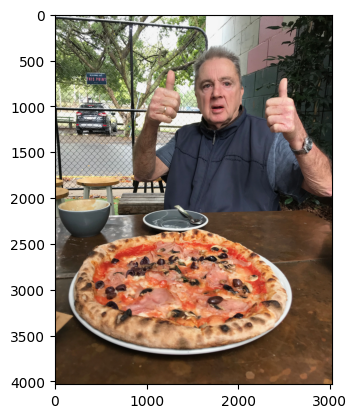

In [81]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [82]:
# need to resize and cast to (or reload as) normalized float32 tensor
from torchvision import transforms

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

custom_image = custom_image_transform(custom_image)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


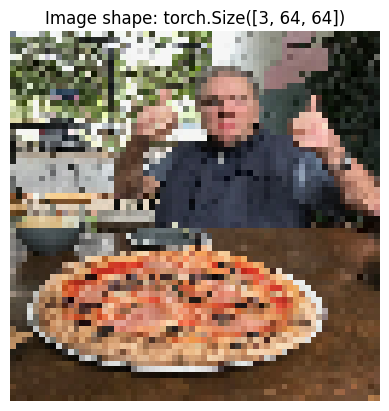

In [83]:
# Plot transformed custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [86]:
# but wait, there's more - now we're going to have a shape error due to the batch size

model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image.to(device))

RuntimeError: ignored

In [88]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [89]:
custom_image_pred # logits

tensor([[ 0.2519, -1.0467, -0.8335]], device='cuda:0')

In [90]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.2519, -1.0467, -0.8335]], device='cuda:0')
Prediction probabilities: tensor([[0.6209, 0.1694, 0.2097]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [91]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [92]:
# functionize this process where an image filepath goes in and method plots image with prediction as the title

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on target image using a trained model and plots the image and prediction"""
  # load the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # normalize the image
  target_image /= 255.

  # transform if necessary
  if transform:
    target_image = transform(target_image)

  # put the model on the target device
  model.to(device)

  # turn on inference mode
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image
    target_image = target_image.unsqueeze(dim=0)

    # Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


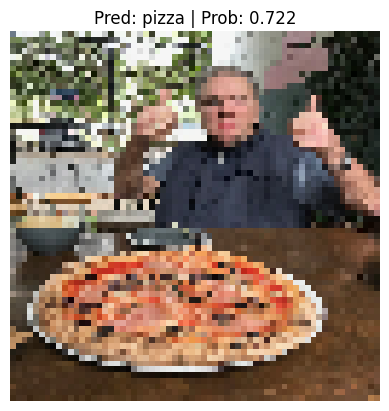

In [95]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)